In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
import tensorflow as tf
import numpy as np

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML

In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


In [8]:
epochs = 50

In [9]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [10]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [12]:
x_inp, x_out = gcn.in_out_tensors()

In [13]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [14]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [16]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 2.4948 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 2.5240
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.4948
	binary_accuracy: 0.5000


In [17]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 0s - loss: 2.4368 - binary_accuracy: 0.5000 - val_loss: 0.7496 - val_binary_accuracy: 0.5876
Epoch 2/50
1/1 - 0s - loss: 0.7531 - binary_accuracy: 0.5840 - val_loss: 4.3698 - val_binary_accuracy: 0.5120
Epoch 3/50
1/1 - 0s - loss: 4.5322 - binary_accuracy: 0.5143 - val_loss: 2.0183 - val_binary_accuracy: 0.5535
Epoch 4/50
1/1 - 0s - loss: 2.2521 - binary_accuracy: 0.5543 - val_loss: 0.6752 - val_binary_accuracy: 0.6522
Epoch 5/50
1/1 - 0s - loss: 0.7088 - binary_accuracy: 0.6424 - val_loss: 0.6842 - val_binary_accuracy: 0.5987
Epoch 6/50
1/1 - 0s - loss: 0.6628 - binary_accuracy: 0.6281 - val_loss: 0.7344 - val_binary_accuracy: 0.5664
Epoch 7/50
1/1 - 0s - loss: 0.7369 - binary_accuracy: 0.5830 - val_loss: 0.7163 - val_binary_accuracy: 0.5867
Epoch 8/50
1/1 - 0s - loss: 0.7296 - binary_accuracy: 0.5994 - val_loss: 0.6990 - val_binary_accuracy: 0.6273
Epoch 9/50
1/1 - 0s - loss: 0.7412 - binary_accuracy: 0.5891 - val_loss: 0.6888 - val_binary_accuracy: 0.6402
Epoch 10/5

Plot the training history:

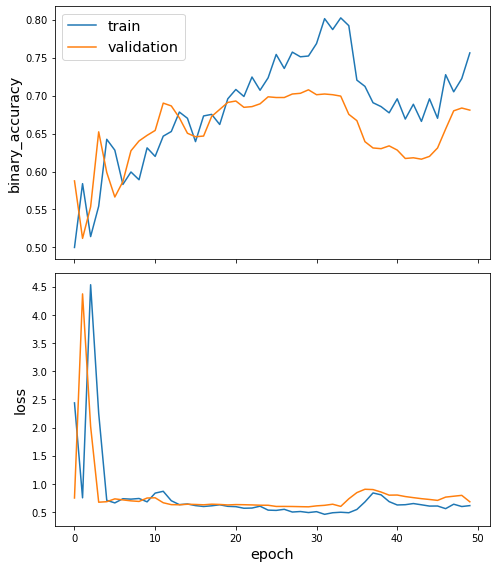

In [18]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 0.6824 - binary_accuracy: 0.6808

Train Set Metrics of the trained model:
	loss: 0.4322
	binary_accuracy: 0.7889

Test Set Metrics of the trained model:
	loss: 0.6824
	binary_accuracy: 0.6808
